# Multi-label Classification

In this exercise we will classify toxic comments from online. 

In [50]:
%matplotlib inline
import re
import matplotlib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from sklearn.multiclass import OneVsRestClassifier
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
import seaborn as sns
from sklearn.multioutput import MultiOutputClassifier
from sklearn.tree import DecisionTreeClassifier

# Data loading

In [43]:
df = pd.read_csv("/dsa/data/DSA-8410/toxic/train.csv", encoding = "ISO-8859-1")
df.head(10)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0
5,00025465d4725e87,"""\n\nCongratulations from me as well, use the ...",0,0,0,0,0,0
6,0002bcb3da6cb337,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,1,1,0,1,0
7,00031b1e95af7921,Your vandalism to the Matt Shirvington article...,0,0,0,0,0,0
8,00037261f536c51d,Sorry if the word 'nonsense' was offensive to ...,0,0,0,0,0,0
9,00040093b2687caa,alignment on this subject and which are contra...,0,0,0,0,0,0


# Data exploration

### T1. Show a distribution of comments over toxic categoies.

In [3]:
df_tmp = df.drop(['id','comment_text'], axis=1)
counts = []
categories = list(df_tmp.columns.values)
for i in categories:
    counts.append((i, df_tmp[i].sum()))
df_stats = pd.DataFrame(counts, columns=['categories', 'number_of_comments'])
df_stats

,categories,number_of_comments
0,toxic,15294
1,severe_toxic,1595
2,obscene,8449
3,threat,478
4,insult,7877
5,identity_hate,1405


(array([0, 1, 2, 3, 4, 5]),
 [Text(0, 0, 'toxic'),
  Text(1, 0, 'severe_toxic'),
  Text(2, 0, 'obscene'),
  Text(3, 0, 'threat'),
  Text(4, 0, 'insult'),
  Text(5, 0, 'identity_hate')])

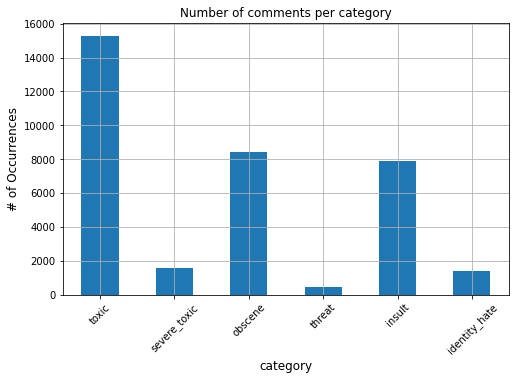

In [9]:
df_stats.plot(x='categories', y='number_of_comments', kind='bar', legend=False, grid=True, figsize=(8, 5))
plt.title("Number of comments per category")
plt.ylabel('# of Occurrences', fontsize=12)
plt.xlabel('category', fontsize=12)
plt.xticks(rotation = 45)

### T2. Show a distribution of number of toxic categories per comment

In [5]:
from pandas import DataFrame

rowsums = df.iloc[:,1:].sum(axis=1)
x=rowsums.value_counts()
df_counts = DataFrame(x, columns=['number_of_comments'])
categories = ['0', '1', '2', '3', '4', '5', '6']
df_counts['number_of_categories'] = categories
df_counts

,number_of_comments,number_of_categories
0,143346,0
1,6360,1
3,4209,2
2,3480,3
4,1760,4
5,385,5
6,31,6


(array([0, 1, 2, 3, 4, 5, 6]),
 [Text(0, 0, '0'),
  Text(1, 0, '1'),
  Text(2, 0, '2'),
  Text(3, 0, '3'),
  Text(4, 0, '4'),
  Text(5, 0, '5'),
  Text(6, 0, '6')])

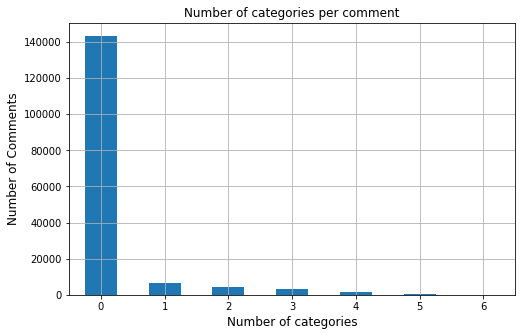

In [59]:
df_counts.plot(x='number_of_categories', y='number_of_comments', kind='bar', legend=False, grid=True, figsize=(8, 5))
plt.title("Number of categories per comment")
plt.ylabel('Number of Comments', fontsize=12)
plt.xlabel('Number of categories', fontsize=12)
plt.xticks(rotation = 0)

### T3. Show a distribution of comment lenght in terms of characters

In [7]:
df_comments = df.drop(['id', 'toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate'], axis=1)
df_comments['length'] = df_comments['comment_text'].str.len()
df_comments.head(10)

,comment_text,length
0,Explanation\nWhy the edits made under my usern...,264
1,D'aww! He matches this background colour I'm s...,112
2,"Hey man, I'm really not trying to edit war. It...",233
3,"""\nMore\nI can't make any real suggestions on ...",622
4,"You, sir, are my hero. Any chance you remember...",67
5,"""\n\nCongratulations from me as well, use the ...",67
6,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,44
7,Your vandalism to the Matt Shirvington article...,115
8,Sorry if the word 'nonsense' was offensive to ...,472
9,alignment on this subject and which are contra...,70


In [8]:
df_comments['length'].nunique

<bound method IndexOpsMixin.nunique of 0         264
1         112
2         233
3         622
4          67
         ... 
159566    295
159567     99
159568     81
159569    116
159570    189
Name: length, Length: 159571, dtype: int64>

In [23]:
df_lengths = df_comments.groupby('length').count().reset_index()
df_lengths.columns = ['length','count']
df_lengths = df_lengths.sort_values('length')
df_lengths

,length,count
0,6,2
1,8,3
2,12,2
3,13,1
4,14,4
...,...,...
4084,5028,2
4085,5031,1
4086,5079,1
4087,5263,1


(array([   0,    1,    2, ..., 4086, 4087, 4088]),
 [Text(0, 0, '6'),
  Text(1, 0, '8'),
  Text(2, 0, '12'),
  Text(3, 0, '13'),
  Text(4, 0, '14'),
  Text(5, 0, '15'),
  Text(6, 0, '16'),
  Text(7, 0, '17'),
  Text(8, 0, '18'),
  Text(9, 0, '19'),
  Text(10, 0, '20'),
  Text(11, 0, '21'),
  Text(12, 0, '22'),
  Text(13, 0, '23'),
  Text(14, 0, '24'),
  Text(15, 0, '25'),
  Text(16, 0, '26'),
  Text(17, 0, '27'),
  Text(18, 0, '28'),
  Text(19, 0, '29'),
  Text(20, 0, '30'),
  Text(21, 0, '31'),
  Text(22, 0, '32'),
  Text(23, 0, '33'),
  Text(24, 0, '34'),
  Text(25, 0, '35'),
  Text(26, 0, '36'),
  Text(27, 0, '37'),
  Text(28, 0, '38'),
  Text(29, 0, '39'),
  Text(30, 0, '40'),
  Text(31, 0, '41'),
  Text(32, 0, '42'),
  Text(33, 0, '43'),
  Text(34, 0, '44'),
  Text(35, 0, '45'),
  Text(36, 0, '46'),
  Text(37, 0, '47'),
  Text(38, 0, '48'),
  Text(39, 0, '49'),
  Text(40, 0, '50'),
  Text(41, 0, '51'),
  Text(42, 0, '52'),
  Text(43, 0, '53'),
  Text(44, 0, '54'),
  Text(45, 0, '5

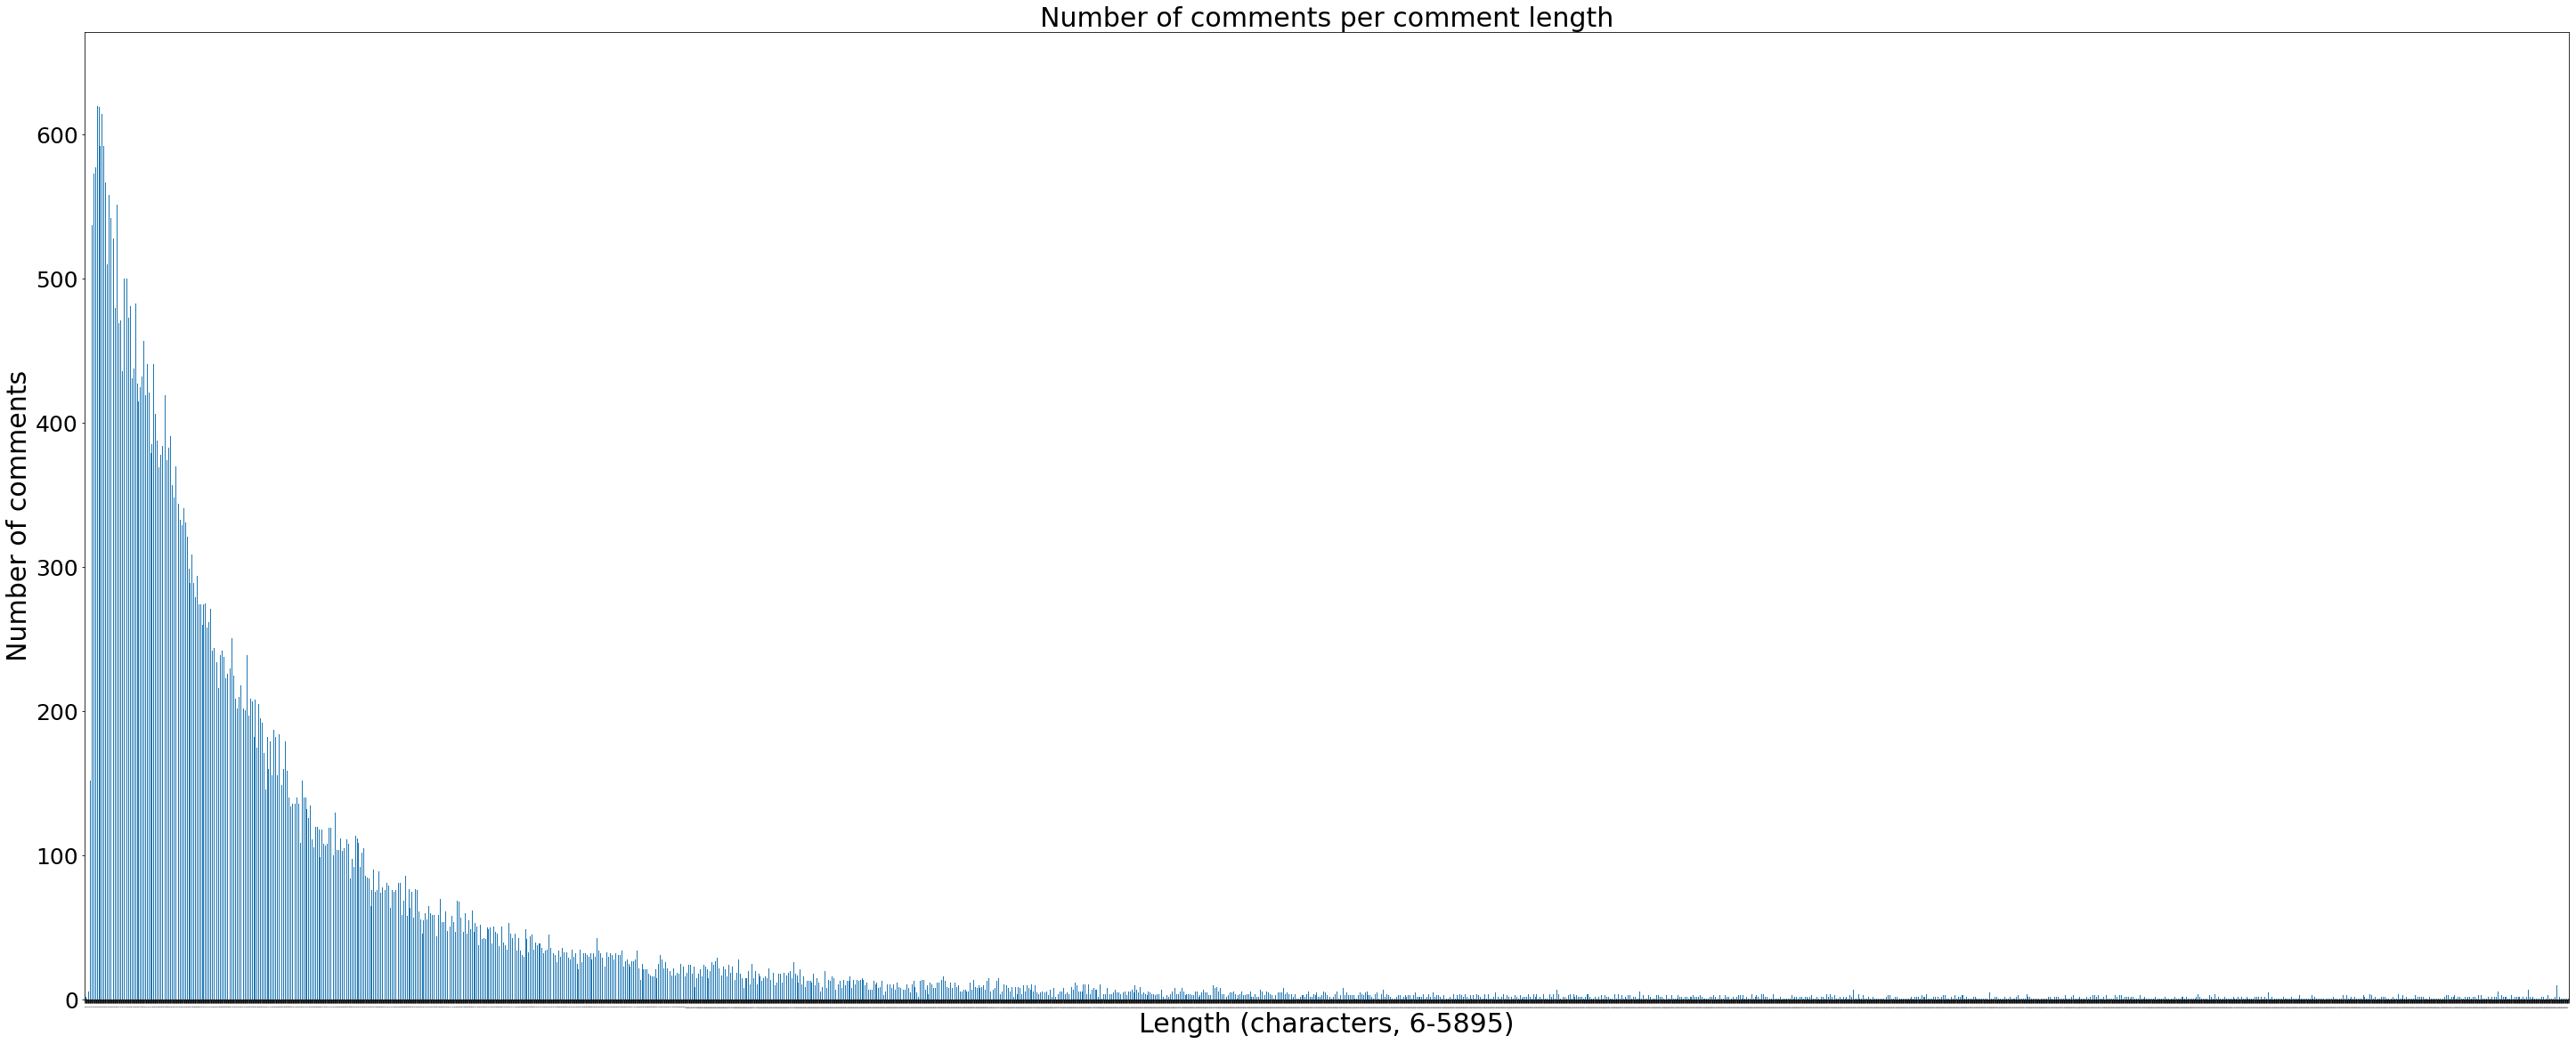

In [60]:
df_lengths.plot(x='length', y='count', kind='bar', legend=False, grid=False, figsize=(50, 20))
plt.title("Number of comments per comment length", fontsize = 30)
plt.ylabel('Number of comments', fontsize=30)
plt.xlabel('Length (characters, 6-5895)', fontsize=30)
plt.yticks(fontsize=25)
plt.xticks(fontsize=1, rotation=45)

### T4. Show five randomly picked comments

In [28]:
df.sample(n=5)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
62708,a7c8bc3a033b4a72,No worries. Maybe one day such a source will t...,0,0,0,0,0,0
4030,0ac5906b808ab22a,"Do it Our Way (Play) \n\nBruv... fuck off, I b...",1,0,1,0,0,0
141961,f765b7d326955caf,"""\n\n sincere reply to Ninlil \n Dear Ninhil,...",0,0,0,0,0,0
137155,ddd595fa75ef09be,Where does it have 3 versions? There's only on...,0,0,0,0,0,0
141583,f56ecdc631c4b1c4,REDIRECT User:R.D.H. (Ghost In The Machine),0,0,0,0,0,0


# Text cleaning

Let's use the following funciton as a black box for text cleaning. 

In [29]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "can not ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r"\'scuse", " excuse ", text)
    text = re.sub('\W', ' ', text)
    text = re.sub('\s+', ' ', text)
    text = text.strip(' ')
    return text

### T5. Apply the above function and clean the comment texts. 

In [33]:
df['comment_text'] = df.comment_text.apply(clean_text)

In [34]:
df.head(10)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,explanation why the edits made under my userna...,0,0,0,0,0,0
1,000103f0d9cfb60f,d aww he matches this background colour i am s...,0,0,0,0,0,0
2,000113f07ec002fd,hey man i am really not trying to edit war it ...,0,0,0,0,0,0
3,0001b41b1c6bb37e,more i can not make any real suggestions on im...,0,0,0,0,0,0
4,0001d958c54c6e35,you sir are my hero any chance you remember wh...,0,0,0,0,0,0
5,00025465d4725e87,congratulations from me as well use the tools ...,0,0,0,0,0,0
6,0002bcb3da6cb337,cocksucker before you piss around on my work,1,1,1,0,1,0
7,00031b1e95af7921,your vandalism to the matt shirvington article...,0,0,0,0,0,0
8,00037261f536c51d,sorry if the word nonsense was offensive to yo...,0,0,0,0,0,0
9,00040093b2687caa,alignment on this subject and which are contra...,0,0,0,0,0,0


# Model development

### T6. Split data into train (80%) and test (20%)

In [44]:
df = df.drop(['id'], axis=1)
X = df["comment_text"]
y = np.asarray(df[df.columns[1:]])

vetorizer = TfidfVectorizer(max_features=1000, max_df=0.85)
vetorizer.fit(X)

TfidfVectorizer(max_df=0.85, max_features=1000)

In [45]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

### T7. Define and train a multi-label (aka multioutput) classifier. Pick a suitable classifier as a base estimator. 

In [46]:
X_train_tfidf = vetorizer.transform(X_train)
X_test_tfidf = vetorizer.transform(X_test)

In [51]:
clf = MultiOutputClassifier(DecisionTreeClassifier())

In [52]:
clf.fit(X_train_tfidf, y_train)
val_preds = clf.predict(X_test_tfidf)

### T8. Estimate accuracy

In [53]:
acc = np.sum(val_preds==y_test) / (y_test.shape[0]*y_test.shape[1])
print(f"Acc: {acc:.2}")

Acc: 0.97


## T9. Qualitative evaluation: Create a subset of comments where the number of predicted tags is three. Take the first ten comments and show their text, true toxic categories, and predicted categories. Write a brief comment about your observations.

In [58]:
pos = np.where(np.sum(y_test, 1) == 3)[0]
pos = pos[:10]

categories = df.columns[1:]

for _idx in pos:
    
    print("Comment: ", X_test.iloc[_idx])
    tcol = np.where(y_test[_idx] == 1)[0]
    print("Actual category: ", [categories[i] for i in tcol])
    tcol = np.where(val_preds[_idx] == 1)[0]
    print("Predicted category: ", [categories[i] for i in tcol])
    print("=" * 80)
    print()

Comment:  Nearly Headless Nick 

Nearly Headless Nick is fucked up in the head and abueses his admin role!
Actual category:  ['toxic', 'obscene', 'insult']
Predicted category:  ['severe_toxic', 'threat']

Comment:  Hitler is an asshole.
Actual category:  ['toxic', 'obscene', 'insult']
Predicted category:  ['toxic', 'obscene', 'insult']

Comment:  i never found it a supportive environment myself. you are speaking of an aspiration perhaps rather than the reality of wikipedia. In the meantime your suggestion  that my remark to petrikrohn fascist could be misinterpreted is puzzling. it means he is a fucking lying fascist. how can that be misinterpreted.  please  stop with your specious humbug.
Actual category:  ['toxic', 'obscene', 'insult']
Predicted category:  ['toxic', 'obscene']

Comment:  u guys are dushbags!!!!!
Actual category:  ['toxic', 'obscene', 'insult']
Predicted category:  ['toxic']

Comment:  MOtherfucker, you have already broken the rule of 3-reverts.  you are obviously a m

Overall we can see that this classifier is quite accurate. It reported an accuracy of .97, and most of the ones which I printed are quite accurate. Though it is surprising that there are some with 3 toxic categories when the model predicted that it would be zero.